Connected to MARE (Python 3.12.10)

In [ ]:
import pandas as pd
import numpy as np
import os
import re
import math
import ast
import pyproj
from pykrige import UniversalKriging as UK
from pykrige.rk import Krige
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from geopandas import gpd
from sklearn.base import clone 
import matplotlib.pyplot as plt
import datetime
import rasterio as rio
from rasterio.mask import mask
from rasterio import transform as riotransform
from rasterio.enums import Resampling
from rasterio.features import rasterize
np.random.seed(42)
######################################################################################################################################################
### Function Junction
# Function for getting the best model from mdls
def get_metrics(df):
  predictive_cols = [col for col in df.columns if col.endswith('_preds')]
  metrics = []
  for col in predictive_cols:
    mse = mean_squared_error(df['max_value'], df[col])
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(df['max_value'], df[col])
    metrics.append({
      'Model': col,
      'RMSE': rmse,
      'MAE': mae,
      'MSE': mse})
  metrics_df = pd.DataFrame(metrics).sort_values(by='RMSE')
  print(f'  Best Method: {metrics_df.iloc[0]['Model']}')
  best_predictive_column = metrics_df.iloc[0]['Model']
  return best_predictive_column
# Data Paths
def load_multiband_raster(day,
                          temporal_type: str,
                          image_path: str):
  """
  Reads in a multiband raster as a usable dataframe for prediciton. Returns the data, transform info, and metadata
  
  Returns
  -------
  data : np.ndarray           # shape (bands, rows, cols)
  transform : Affine          # affine for the raster
  meta : dict                 # metadata
  """
  flat_data = {}
  band_start=0
  with rio.open(image_path) as src:
    bands = list(src.descriptions)
    meta = src.meta.copy()
    transform=src.transform
    for val in bands:
      band_start+=1
      flat_data[f'{val}'] = src.read(band_start).flatten()
  pred_features = pd.DataFrame.from_dict(flat_data)
  pred_features.columns=bands
  if not temporal_type is None:
    pred_features=add_binary_cols(pred_features,temporal_type,day)
  return pred_features, transform, meta, bands
# Creates a mask to retain features to
def create_high_res_mask(res=30, 
                         aoi_path='C:\\Users\\ryane\\Documents\\Github\\UCBMasters\\data\\study_area\\study_area.shp',
                         file_name = 'mask_30m',
                         output_folder= str):
  """
  Returns a mask for the AOI of a given resolution. File name is mask_30m by default
  
  Returns
  -------
  aoi_path : `str` path to masked raster.            
  """
  out_path = os.path.join(output_folder,f"{file_name}.tif")
  if os.path.exists(output_folder) and out_path in output_folder:
    with rio.open(out_path) as mersk:
      bool_mask = mersk.read(1)
  else:
    os.makedirs(output_folder, exist_ok=True)
    pred_extent = gpd.read_file(aoi_path)
    if pred_extent.crs.is_geographic:
      pred_extent = pred_extent.to_crs(epsg=4326)
    minx, miny, maxx, maxy = pred_extent.total_bounds
    res = res
    width = int((maxx - minx) / res)
    height = int((maxy - miny) / res)
    transform = riotransform.from_origin(minx, maxy, res, res)  # top-left origin
    shapes = [(geom, 1) for geom in pred_extent.geometry]
    raster = rasterize(shapes=shapes,out_shape=(height, width),transform=transform,fill=0,dtype='uint8')
    bool_mask = raster.astype(bool)
    with rio.open(out_path, "w",driver="GTiff",height=height,width=width,count=1,dtype="uint8",crs=pred_extent.crs,transform=transform) as dst:
      dst.write(raster, 1)
  return out_path, bool_mask
# Get Lats and Longs
def get_lat_lon(transform, height, width):
    rows, cols = np.indices((height, width))
    x_coords, y_coords = riotransform.xy(transform, rows, cols)
    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)
    return y_coords, x_coords
# Quick Maps of Features
def display_raster_bands(day=str,path_to_features=str, col_nms=str,title=str,stylex=5,styley=2):
  names_dict = {
    'max_value':'Average Monthly O3',
    'down_srad': 'Downward Shortwave\n(D.S) Radiation', 
    'max_surf_temp': 'Max Surface Temperature',
    'vprps_def': 'Mean Pressure Deficit',
    'strat_no2': 'Stratospheric NO2',
    'tco_temp': 'S5P TCO Temperature',
    'ke_oz': 'TOMs/OMI Kinetic Energy', 
    's5p_ke_oz': 'S5P Kinetic Energy',
    'down_srad_moving_wkly_average' : 'D.S Radiation Weekly Moving Average',
    'tco_temp_moving_wkly_average' : 'S5P TCO Temperature Weekly Moving Average',
    'Winter': 'Winter',
    'Spring': 'Spring',
    'Summer': 'Summer',
    'Fall': 'Fall'}
  feature_paths = os.path.join(os.path.expanduser('~'), "Documents", "Github", "UCBMasters", "data","results","feature_plots")
  if not os.path.exists(feature_paths):
    os.makedirs(feature_paths, exist_ok=True)
  with rio.open(path_to_features) as fts:
    n_bands = len(fts.descriptions)
    fig, axes = plt.subplots(stylex, styley, figsize=(10,16))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
      if i < n_bands:
        band = fts.read(i+1)
        valid_mask = (~np.isnan(band)) & (band > -10)
        valid_values = band[valid_mask]
        vmin, vmax = valid_values.min(), valid_values.max()
        band_masked = np.ma.masked_array(band, mask=~valid_mask)
        im = ax.imshow(band_masked,cmap="plasma",vmin=vmin,vmax=vmax,interpolation="nearest")
        band_name = names_dict.get(col_nms[i], f"Band {i+1}")  # fall-back label
        ax.set_title(band_name, fontsize=9)
        ax.set_xlabel(f"min={vmin:0.4f}\nmax={vmax:0.4f}",fontsize=7)
        fig.colorbar(im, ax=ax, orientation="vertical", shrink=0.8)
      else:
        ax.axis('off')
    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(left=0.005, bottom=0.015, right=0.995, top=0.935, wspace=0.03, hspace=0.35)
  plt.tight_layout(rect=(0, 0, 1, 0.95))
  plt.savefig(os.path.join(feature_paths,f"features_{day}.png"),dpi=500)
  plt.close()
# Map of Predicitons
def plot_surf_o3(day,path):
  with rio.open(path, 'r') as src:
    raster_data = src.read(1)
    masked_data = np.ma.masked_greater_equal(raster_data, 0.98)
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.imshow(masked_data, cmap='viridis')
    cbar = fig.colorbar(cax, ax=ax, label='Pixel Values')
    plt.title(f'Raster Data: {day}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()
# Function to add binary data to prediciton grid
def add_binary_cols(df, time_type, date=str):
  dte = pd.to_datetime(date).month
  og_cols = list(df.columns.values)
  seas = ['Winter','Spring','Summer','Fall']
  months_list=[]
  df['Winter'] = False
  df['Spring'] = False
  df['Summer'] = False
  df['Fall'] = False
  for i in range(1, 13):
    df[f'month_{i}'] = False
    months_list.append(f'month_{i}')
  df[f'month_{dte}'] = True
  if dte in [12, 1, 2]:
    df['Winter'] = True
  elif dte in [3, 4, 5]:
    df['Spring'] = True
  elif dte in [6, 7, 8]:
    df['Summer'] = True
  elif dte in [9, 10, 11]:
    df['Fall'] = True
  if time_type=='monthly':
    out_df=df[og_cols+months_list]
  elif time_type=='seasonal':
    out_df=df[og_cols+seas]
  else:
    out_df=df[og_cols]
    print('Warning: Temporal Variable type not selected, exporting dataframe with no time depicitons\nchoices: seasonal, monthly')
  return out_df
# Drift (Fourier Series)
def drift_funcFT(x, y):
  ftd = list(zip(x, y))
  z = np.fft.rfft2(a=ftd)
  return z
# Creating Temporal Variables - Date, List of tuples containing the feature name, band, and path the feature resides at 
def get_wka_vars(day, oz_path, mask_bools, var_source, band=int, path=str):
  dt = pd.to_datetime(day)
  moving_mean_list = [(dt + pd.Timedelta(days=i)).strftime("%Y-%m-%d") for i in range(7)]
  date_set = set(moving_mean_list)
  date_pat = re.compile(r"\d{4}-\d{2}-\d{2}")
  matching_files = [fname for fname in os.listdir(path) if (m := date_pat.search(fname)) and m.group(0) in date_set]
  path_list = [os.path.join(path, i) for i in matching_files]
  data = []
  with rio.open(oz_path, 'r') as base:
    band_names = list(base.descriptions)
    ref_shape = (base.height, base.width)
    ref_crs = base.crs
    ref_res = base.res
    ref_meta = base.profile
    ref_data = base.read()
    ref_meta.update(count=ref_data.shape[0] + 1, dtype='float32')
    band_names.append('_w')
    for tif in path_list:
      with rio.open(tif) as src:
        arr = src.read(band).astype('float32')
        nodata = src.nodata
        if nodata is not None:
          arr[arr == src.nodata] = 0
        if src.shape != ref_shape or src.res != ref_res or src.crs != ref_crs:
          arr = src.read(band, out_shape=ref_shape,resampling=Resampling.cubic_spline).astype('float32')
        data.append(arr)
    stack = np.stack(data)
    result = stack.mean(axis=0)
  with rio.open(oz_path, 'w', **ref_meta) as dst:
    for i in range(ref_data.shape[0]):
      dst.set_band_description(i+1, band_names[i])
      dst.write(ref_data[i], i+1)
    if isinstance(mask_bools, np.ndarray) and mask_bools.any():
      data = np.where(mask_bools, result, np.nan)
    else:
      data = result
    dst.set_band_description(ref_data.shape[0] + 1, f'{var_source}_moving_wkly_average')
    dst.write(data, ref_data.shape[0] + 1)
  return oz_path
# Making Multibanded Raster for Predictions
def get_feature_dict(col_names,
                     data_path=os.path.join(os.path.expanduser('~'), 'Documents','Github','UCBMasters','data','tifs')):
  """  
  SMaRK Necessary
  -------
  Creates a dictionary to use for mk_pred_grid. Returns satellite imagery based features and remaining features which need to be created in the function.
  
  Returns
  -------
  pd.Dataframe : Satellite based data.
  list : Remaining features 
  
  Additional Info
  -------
  Requries a list of desired dependent variables and path to data from GEE for use in prediciton. 
  """
  feature_dict = {'pred_feature':[],
                  'band_num':[],
                  'folder_path':[]}
  remaining = []
  band_asctns=pd.DataFrame({'bands':[['precip','spf_hmdty','down_srad','min_surf_temp','max_surf_temp','wdsp','bnid','vprps_def'],# False
                                     ['ntl'],# False
                                     ['arsl_idx'],# True
                                     ['stdzd_pressure','stdzd_height','cloud_fraction'],# True
                                     ['no2_cnd','strat_no2'],# True
                                     ['carmon_cnd'],# True
                                     ['tco_nd','tco_temp'],# True
                                     ['ozone'],# False
                                     ['ndvi'],# False
                                     ['tcd_formald','tcd_formald_amf','tcd_formald_slant']],  # True
                            's5p_sourced':[False,False,True,True,True,True,True,False,False,True],
                            'folder_name':['gridmet','ntl','aerosols','clouds','no2','co','o_3_1km','ozone10km','ndvi','hcho']})
  for add in col_names:
    matched = False
    for i, row in band_asctns.iterrows():
      if add in row['bands']:
        band_num = row['bands'].index(add) + 1 
        if row['s5p_sourced']:
          folder_path = os.path.join(data_path,'s5p', row['folder_name'],'daily')
        else:
          folder_path = os.path.join(data_path, row['folder_name'],'daily')
        feature_dict['pred_feature'].append(add)
        feature_dict['band_num'].append(band_num)
        feature_dict['folder_path'].append(folder_path)
        matched = True
        break
    if not matched:
      remaining.append(add)
  return pd.DataFrame(feature_dict), remaining
# Adds Kinetic Energy Gas Law to existing feature raster with proper variables
def get_ke_est(day, outpath, mask):
  path_to_tomi_imagery = os.path.join(os.path.expanduser('~'), 'Documents', 'Github', 'UCBMasters', 'data', 'tifs', 'ozone10km', 'daily')
  path_to_tomi = os.path.join(path_to_tomi_imagery, next((tom for tom in os.listdir(path_to_tomi_imagery) if day in tom), None))
  path_to_s5p_imagery = os.path.join(os.path.expanduser('~'), 'Documents', 'Github', 'UCBMasters', 'data', 'tifs', 's5p', 'o_3_1km', 'daily')
  path_to_s5p = os.path.join(path_to_s5p_imagery, next((s5p for s5p in os.listdir(path_to_s5p_imagery) if day in s5p), None))
  with rio.open(outpath) as dst:
    base_data = dst.read()
    semi_names = list(dst.descriptions)
    profile = dst.profile.copy()
    height, width = dst.height, dst.width
  with rio.open(path_to_tomi) as tomi:
    ozone = tomi.read(1, out_shape=(height, width), resampling=Resampling.cubic_spline).astype('float32')
  with rio.open(path_to_s5p) as sent5p:
    tco_nd = sent5p.read(1, out_shape=(height, width), resampling=Resampling.cubic_spline).astype('float32')
  if isinstance(mask, np.ndarray) and mask.any():
    ozone = np.where(mask, ozone, np.nan)
    tco_nd = np.where(mask, tco_nd, np.nan)
  down_srad = base_data[semi_names.index('down_srad')]
  max_surf_temp = base_data[semi_names.index('max_surf_temp')]
  tco_temp = base_data[semi_names.index('tco_temp')]
  ke_oz = (down_srad * (ozone * 0.00021441) * max_surf_temp * 0.08206)
  s5p_ke_oz = (down_srad * tco_nd * tco_temp * 0.08206)
  profile.update(count=base_data.shape[0] + 2, dtype='float32')
  with rio.open(outpath, 'w', **profile) as out_raster:
    for i, col in enumerate(semi_names):
      out_raster.write(base_data[i], i + 1)
      out_raster.set_band_description(i + 1, col)
    out_raster.write(ke_oz, len(semi_names) + 1)
    out_raster.set_band_description(len(semi_names) + 1, 'ke_oz')
    out_raster.write(s5p_ke_oz, len(semi_names) + 2)
    out_raster.set_band_description(len(semi_names) + 2, 's5p_ke_oz')
  return outpath
# makes a predictive grid containing all features except boolean based dummy features such as seasonal features. 
def mk_pred_grid(day=str,dep_feats=list,msk=False,msk_file_nme=None,res=30):
  """  
  SMaRK Necessary
  -------
  Creates a grid of all dependent variables. The grid can be cropped via mask which is readable by Geopandas.read_file().
  Recommended geometry file format: shapefile (.shp)
  
  Returns
  -------
  str : Path to resulting feature grid.
  np.nDarray,  
  
  Additional Info
  -------
  Requries a day and list of dependent variables to use for a stacked raster. If mask is a path to a .shp object, the resulting raster will include an output path to the create mask. 
  """
  if not isinstance(day, str) or not isinstance(dep_feats, list):
    raise ValueError("Expected `day` as str and `dep_feats` as list")
  sat_vars, rem_vars = get_feature_dict(dep_feats)
  grid_path = os.path.join(os.path.expanduser('~'), 'Documents', 'Github', 'UCBMasters', 'data', 'tifs', 'predicted_grids')
  os.makedirs(grid_path, exist_ok=True)
  output_path = os.path.join(grid_path, f'photuc_surfo3_{day}.tif')
  if os.path.exists(output_path) and not msk:
    return output_path
  elif os.path.exists(output_path) and isinstance(msk, str) and msk_file_nme is not None:
    _, mask_bools = create_high_res_mask(res, msk, f'{msk_file_nme}',os.path.join(os.path.expanduser('~'), 'Documents', 'Github', 'UCBMasters', 'data','study_area','mask'))
    return output_path, mask_bools
  elif isinstance(msk, str) and msk_file_nme is not None:
    start, mask_bools = create_high_res_mask(res, msk, f'{msk_file_nme}',os.path.join(os.path.expanduser('~'), 'Documents', 'Github', 'UCBMasters', 'data','study_area','mask'))
  else:
    print("`msk` must be False or a valid path to a shapefile, writing grid with no mask...")
    start = sat_vars.iloc[0, 2]
    mask_bools = False
  with rio.open(start) as base:
    meta = base.profile.copy()
    meta.update(count=len(sat_vars), dtype='float32')
    with rio.open(output_path, 'w+', **meta) as out_raster:
      for i, (_, row) in enumerate(sat_vars.iterrows(), start=1):
        feature_name = row['pred_feature']
        band_num = row['band_num']
        folder = row['folder_path']
        fname = next((col for col in os.listdir(folder) if day in col), None)
        if fname is None:
          raise ValueError(f"No file in {folder} matches the day: {day}")
        spath = os.path.join(folder, fname)
        with rio.open(spath) as src:
          out_raster.set_band_description(i, feature_name)
          if src.res != base.res or src.shape != base.shape or src.crs != base.crs:
            data = src.read(band_num, out_shape=(base.height, base.width), resampling=Resampling.cubic_spline).astype('float32')
          else:
            data = src.read(band_num).astype('float32')
          if data.shape != (base.height, base.width):
            raise ValueError(f"Data shape {data.shape} does not match base shape {(base.height, base.width)}")
          if isinstance(mask_bools, np.ndarray) and mask_bools.any(): # make better for mask options
            data = np.where(mask_bools, data, np.nan)
          else:
            data = data
          out_raster.write(data, i)
  for nbnd in rem_vars:
    if "_moving_wkly_average" in nbnd:
      time_var = nbnd.split("_moving_wkly_average")[0]
      band_num = int(sat_vars.loc[sat_vars['pred_feature']==time_var,'band_num'].values[0])
      folder = str(sat_vars.loc[sat_vars['pred_feature']==time_var,'folder_path'].values[0])
      get_wka_vars(day,output_path,mask_bools,time_var,band_num,folder)
    elif "_ke_oz" in nbnd:
      get_ke_est(day,output_path,mask_bools)
    else:
      continue
  return output_path,mask_bools
# Statistical Model and Residual Krige Prediction of Surface Ozone Values
# train model before making kriged dates
def SMaRK_raster_predictions(day,
                             predictive_model,
                             predictive_features,
                             predictive_params,
                             plot_features = False):
  """
  Returns a set of predictive rasters for the variable of interest (independent variable). If desired, 
  an option to view the features used in prediciton is avaliable with `plot_features = True`.
  
  Returns
  -------
  path : `str` on user machine to the prediction set. Seperate files are used for the Statiistical Model and Residual Kriging.
                 
  """
  final_path = os.path.join(os.path.expanduser('~'), 'Documents','Github','UCBMasters','data','results','final_surfo3')
  os.makedirs(final_path, exist_ok=True)
  ml_path = os.path.join(final_path, 'ml_outputs')
  rk_path = os.path.join(final_path,'rk_outputs')
  os.makedirs(ml_path, exist_ok=True)
  os.makedirs(rk_path, exist_ok=True)
  print(f"Predicting for {day}:") 
  name = get_metrics(predictive_model).split("_", 1)[0]
  model_params = predictive_params.reset_index(drop=True).at[0, f'{name}_params']
  x_dat = predictive_features[predictive_features['date']==day].drop(columns=['site_id','date'])
  y_dat = predictive_model[predictive_model['date']==day].max_value.values.ravel()
  choices ={
    'adaboost':AdaBoostRegressor(random_state=42),
    'gb':GradientBoostingRegressor(criterion='friedman_mse',random_state=42),
    'xgrb':XGBRegressor(booster='gbtree',n_jobs=-1,random_state=42),
    'rf':RandomForestRegressor(random_state=42,n_jobs=-1),
    'mlper':MLPRegressor(activation='tanh',solver='adam',early_stopping=True,random_state=42)}
  use_this = clone(choices[name]).set_params(**ast.literal_eval(model_params))
  print(f'  Fitting Statistical Model: {use_this}')
  scv_best = use_this.fit(X=x_dat, y=y_dat)
  mask_path = os.path.join(os.path.expanduser('~'),'Documents','Github','UCBMasters','data','study_area','study_area.shp')
  print('  Loading raster...')
  feature_raster, mask_array=mk_pred_grid(day,dep_feats=list(x_dat.columns.values),msk=mask_path,msk_file_nme='photuc_mask50m',res=100)
  processed_arrays, transform, metadata, col_names = load_multiband_raster(day,temporal_type='seasonal',image_path=feature_raster)
  bad_mask = processed_arrays.replace([np.inf,-np.inf],np.nan).isna().any(axis=1)
  good_X = processed_arrays.loc[~bad_mask,x_dat.columns] 
  print(f'  Predicting...')
  good_preds=scv_best.predict(good_X)
  ml_surfo3=pd.Series(None,index=processed_arrays.index,name=f"{name}_surfo3")
  ml_surfo3.iloc[good_X.index]=good_preds
  rows,cols=metadata['height'],metadata['width']
  final_raster_array=ml_surfo3.to_numpy().reshape((rows,cols))
  ml_output_path = os.path.join(ml_path,f'surf_o3_mlpreds_{day}.tif')
  metadata.update(count=1)
  with rio.open(ml_output_path, 'w', **metadata) as dst:
    dst.write(final_raster_array.astype(np.float32), 1)
  print("  Finished statistical model predicitons")
  if plot_features:
    try:
      display_raster_bands(day, feature_raster,col_names, title="Dependent Variables")
    except:
      print("Feature Display failed due to unexpected reason")
  rk_params = {
    'variogram_model':['linear','spherical','gaussian'],
    'pseudo_inv': [True],
    'pseudo_inv_type': ['pinvh'],
    'drift_terms': ['function'], 
    'nlags':[4,6,8],
    'functional_drift': [drift_funcFT]}
  training_points = predictive_model[predictive_model['date']==day][['lat','long','max_value',f'{name}_preds']]
  transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:32612", always_xy=True)
  xs, ys = transformer.transform(training_points['long'].values, training_points['lat'].values)
  rows_cols = [riotransform.rowcol(transform, x, y) for x, y in zip(xs, ys)]
  vals = []
  height, width = final_raster_array.shape
  for row, col in rows_cols:
    if 0 <= row < height and 0 <= col < width:
      val = final_raster_array[row, col]
      vals.append(val if not np.isnan(val) else np.nan)
    else:
      vals.append(np.nan)
  training_points[f'{name}_preds'] = vals
  krige_cv=GridSearchCV(Krige(method= "universal",coordinates_type="euclidean"),param_grid=rk_params)
  y_rk=training_points['max_value']-training_points[f'{name}_preds']
  transformed_training=np.array(rows_cols,dtype=float)
  best_krige=krige_cv.fit(X=transformed_training,y=y_rk)
  uk_model=UK(x=transformed_training[:, 0],y=transformed_training[:, 1],z=y_rk,**best_krige.best_params_)
  try:
    with rio.open(ml_output_path) as fin: 
      out_meta = metadata.copy()
      out_raster = os.path.join(rk_path,f'surf_o3_rkpreds_{day}.tif')
      smark_path = os.path.join(final_path,f'surf_o3_{day}.tif')
      rx = np.arange(width, dtype=float)
      ry = np.arange(height, dtype=float)
      z1, _ = uk_model.execute('grid',rx,ry)
      pred_2d = z1.reshape((rows, cols))
      data = np.where(mask_array, pred_2d, np.nan)
      final_rk_array = final_raster_array+data
      out_meta.update({"count":1,"dtype":str(pred_2d.dtype),"compress": "lzw"})
      with rio.open(out_raster,'w+',**out_meta) as fin:
        fin.write(data,1)
      with rio.open(smark_path, 'w+', **metadata) as fin_rk:
        fin_rk.write(final_rk_array.astype(np.float32), 1)
    print('  RK enhancements made, SM raster has been updated.')
  except Exception as e:
    print(f"  Universal Kriging failed, printing model predictions")
    smark_path = os.path.join(final_path,f'surf_o3_{day}.tif')
    with rio.open(smark_path, 'w+', **metadata) as fin:
      fin.write(final_raster_array.astype(np.float32), 1)
  return print(f'  SMaRK Prediction exported for {day}')
###########################################################################

In [ ]:
x_plot=os.path.join(os.path.expanduser('~'), 'Documents', 'Github', 'UCBMasters', 'data', 'tifs', 'predicted_grids')
ysm_plot=os.path.join(os.path.expanduser('~'), 'Documents','Github','UCBMasters','data','results','final_surfo3','ml_outputs')
yrk_plot=os.path.join(os.path.expanduser('~'), 'Documents','Github','UCBMasters','data','results','final_surfo3','rk_outputs')
yfin_plot=os.path.join(os.path.expanduser('~'), 'Documents','Github','UCBMasters','data','results','final_surfo3')
path_to_final_tables = os.path.join(os.path.expanduser('~'), "Documents", "Github", "UCBMasters", "data",'tables','final')
path_to_final_images = os.path.join(os.path.expanduser('~'), "Documents", "Github", "UCBMasters", "writing",'imgs')

income_data = pd.read_csv(os.path.join(os.path.expanduser('~'), "OneDrive", "Desktop",'ozone_map_data','income_pop_tables','ACS_ST_5Y_income_2019.csv'))
shape = gpd.read_file(os.path.join(os.path.expanduser('~'), "Documents", "Github", "UCBMasters", "data",'azcounty','income_shp','photuc_centracts.shp'))
out = os.path.join(os.path.expanduser('~'), "Documents", "Github", "UCBMasters", "data",'tables','mapping','acs5yincome2019.csv')
csv_path = os.path.join(os.path.expanduser('~'), "Documents", "Github", "UCBMasters", "data",'tables','ad_viz_tile_data.csv')
df = pd.read_csv(csv_path)

predictive_params = pd.read_csv(os.path.join(path_to_final_tables,'theory_model_results.csv'),index_col=0)
predictive_features = pd.read_csv(os.path.join(path_to_final_tables,'theory_goat_model_params.csv'),index_col=0)
predictive_model = pd.read_csv(os.path.join(path_to_final_tables,'theory_goat_model_features.csv'),index_col=0)

In [ ]:
predictive_model

,site_id,date,ln_cloud_energy,vprps_def,s5p_ke_oz,strat_no2,ndvi,wdsp_moving_wkly_average,bnid,Fall,Spring,Summer,Winter
0,40130019,2019-01-01,1.555366,0.319800,387.732300,0.000034,0.197089,1.741593,34.980537,False,False,False,True
1,40130019,2019-01-02,1.000000,0.519703,408.346341,0.000030,0.195940,1.570315,34.959068,False,False,False,True
2,40130019,2019-01-03,1.000000,0.639416,324.804495,0.000023,0.194792,1.398968,32.964802,False,False,False,True
3,40130019,2019-01-04,1.000000,0.949400,302.065889,0.000023,0.193643,1.213013,33.978268,False,False,False,True
4,40130019,2019-01-05,0.972568,0.949088,189.088516,0.000022,0.192494,1.327283,0.000000,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65245,40218001,2024-12-10,1.000000,1.290273,357.985272,0.000030,0.215356,1.813483,64.377228,False,False,False,True
65246,40218001,2024-12-11,0.885876,1.634326,331.695501,0.000031,0.214517,2.025110,70.214760,False,False,False,True
65247,40218001,2024-12-12,1.039443,1.863397,270.336685,0.000033,0.213678,2.403148,80.562202,False,False,False,True
65248,40218001,2024-12-13,1.000000,1.164872,343.797854,0.000035,0.212839,2.440454,58.658276,False,False,False,True


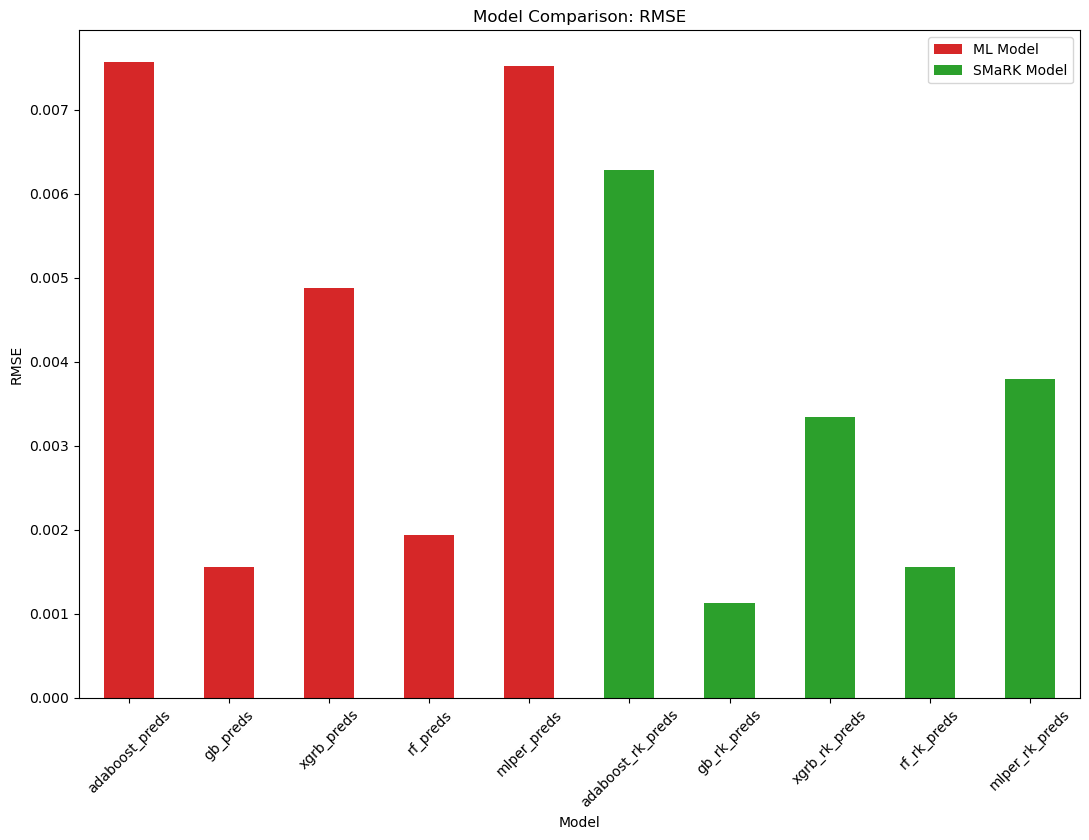

In [ ]:
predictive_model = pd.read_csv(os.path.join(path_to_final_tables,'theory_model_results.csv'),index_col=0)
predictive_params = pd.read_csv(os.path.join(path_to_final_tables,'theory_goat_model_params.csv'),index_col=0)
predictive_features = pd.read_csv(os.path.join(path_to_final_tables,'theory_goat_model_features.csv'),index_col=0)



# hist_results = pd.read_csv(os.path.join(predictive_model,'hist_model_results_seasons.csv'))
# modern_results = pd.read_csv(os.path.join(path_to_final_tables,'modern_model_results_seasons.csv'),index_col=0)
# theory_results = pd.read_csv(os.path.join(predictive_model,'theory_model_results.csv'))
# goat_results = pd.read_csv(os.path.join(predictive_model,'goat_model_results.csv'))

# Comparitive Bar plot of ML (Red) vs. SMaRK (Green) Estimated RMSE in PPM
smark = [col for col in predictive_model.columns if col.endswith('rk_preds')]
ml = [col for col in predictive_model.columns if col.endswith('_preds') and col not in smark]
metrics = []
for col in ml+smark:
  # Drop rows where either prediction or max_value is NaN
  valid = predictive_model[[col, 'max_value']].dropna()
  rmse = np.sqrt(np.mean((valid[col] - valid['max_value'])**2))
  mae = np.mean(np.abs(valid[col] - valid['max_value']))
  metrics.append({'Model': col, 'RMSE': rmse, 'MAE': mae})
metrics_df = pd.DataFrame(metrics).set_index('Model')
bar_colors = []
for model in metrics_df.index:
    if model in smark:
        bar_colors.append('tab:green')  # SMaRK models
    else:
        bar_colors.append('tab:red')    # ML models
fig, ax = plt.subplots(figsize=(11, 8.5))
metrics_df['RMSE'].plot(kind='bar', ax=ax, color=bar_colors, rot=45)
ax.set_ylabel('RMSE')
ax.set_title('Model Comparison: RMSE')
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='tab:red', label='ML Model'),
                   Patch(facecolor='tab:green', label='SMaRK Model')]
ax.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

In [ ]:
def preds_over_time(df,fname=""):
  path_to_final_images = os.path.join(os.path.expanduser('~'),'Documents','Github','UCBMasters','writing','imgs')
  final_path = os.path.join(path_to_final_images,fname)
  df=predictive_model.copy()
  df['date'] = pd.to_datetime(df['date'])
  df['county'] = df['site_id'].astype(str).str[:4].map({
      '4013': 'Maricopa',
      '4021': 'Pinal',
      '4019': 'Pima'
  }).fillna('Other')
  df = df.groupby(['county', 'date']).mean(numeric_only=True).reset_index()
  raw_vars = ['adaboost_preds',
              'gb_preds',
              'xgrb_preds',
              'mlper_preds']
  rk_vars  = [col for col in df.columns if col.endswith('_rk_preds')]
  color_map = {
      'adaboost_preds':  '#0000FF',
      'gb_preds':        '#FF0000',
      'xgrb_preds':      '#00FF00',
      'mlper_preds':     '#FF00FF'
  }
  counties = ['Maricopa', 'Pinal', 'Pima']
  fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8.5, 11), sharex=True, sharey=True)
  for i, county in enumerate(counties):
      data = df[df['county'] == county].sort_values('date')
      ax_raw = axes[i, 1]
      ax_raw.plot(data['date'], data['max_value'], color='black',linewidth=1)
      if i == 0:
          ax_raw.axhline(0.07, color='red', linestyle='--', linewidth=1, label='EPA Standard')
      else:
          ax_raw.axhline(0.07, color='red', linestyle='--', linewidth=1, label='_nolegend_')
      for var in raw_vars:
          ax_raw.plot(data['date'], data[var],
                      label=var.replace('_preds', ''),
                      color=color_map[var],
                      alpha=0.5,linewidth=0.5)
      ax_raw.set_title(f"{county}",loc='right')
      ax_raw.set_ylabel("Estimated Surface O$_{3}$ (ppm)")
      ax_raw.set_ylim(bottom=0.01, top=0.09)
      ax_raw.set_xlim(left=pd.Timestamp("2023-01-01"), right=pd.Timestamp("2023-12-31"))
      if i == 2:
          ax_raw.set_xlabel("Ensemble Predictions")
      ax_rk = axes[i, 0]
      ax_rk.plot(data['date'], data['max_value'], color='black',linewidth=1)
      if i == 0:
          ax_rk.axhline(0.07, color='red', linestyle='--', linewidth=1, label='EPA Standard')
      else:
          ax_rk.axhline(0.07, color='red', linestyle='--', linewidth=1, label='_nolegend_')
      for var in rk_vars:
          ax_rk.plot(data['date'], data[var],
                     color=color_map.get(var.replace('_rk_preds', '_preds')),
                     alpha=0.5,linewidth=0.5)
      ax_rk.set_title("County",loc='left')
      ax_rk.set_ylim(bottom=0.01, top=0.09)
      ax_rk.set_xlim(left=pd.Timestamp("2024-01-01"), right=pd.Timestamp("2024-12-01"))
      if i == 2:
          ax_rk.set_xlabel("RK Enhancements")
      if i == 0:
          legend_handles, legend_labels = ax_raw.get_legend_handles_labels()
  avgh=Line2D([0], [0], color='#000000', linewidth=1, label='Average')
  legend_handles = [avgh] + legend_handles
  legend_labels = ['Average'] + [label.upper() for label in legend_labels]
  fig.legend(legend_handles, legend_labels, title="SMaRK Enhancement of Predicted Values Over Time", fontsize="small", loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.00))
  fig.autofmt_xdate(rotation=30, ha='right')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.savefig(final_path,dpi=500)
  plt.show()

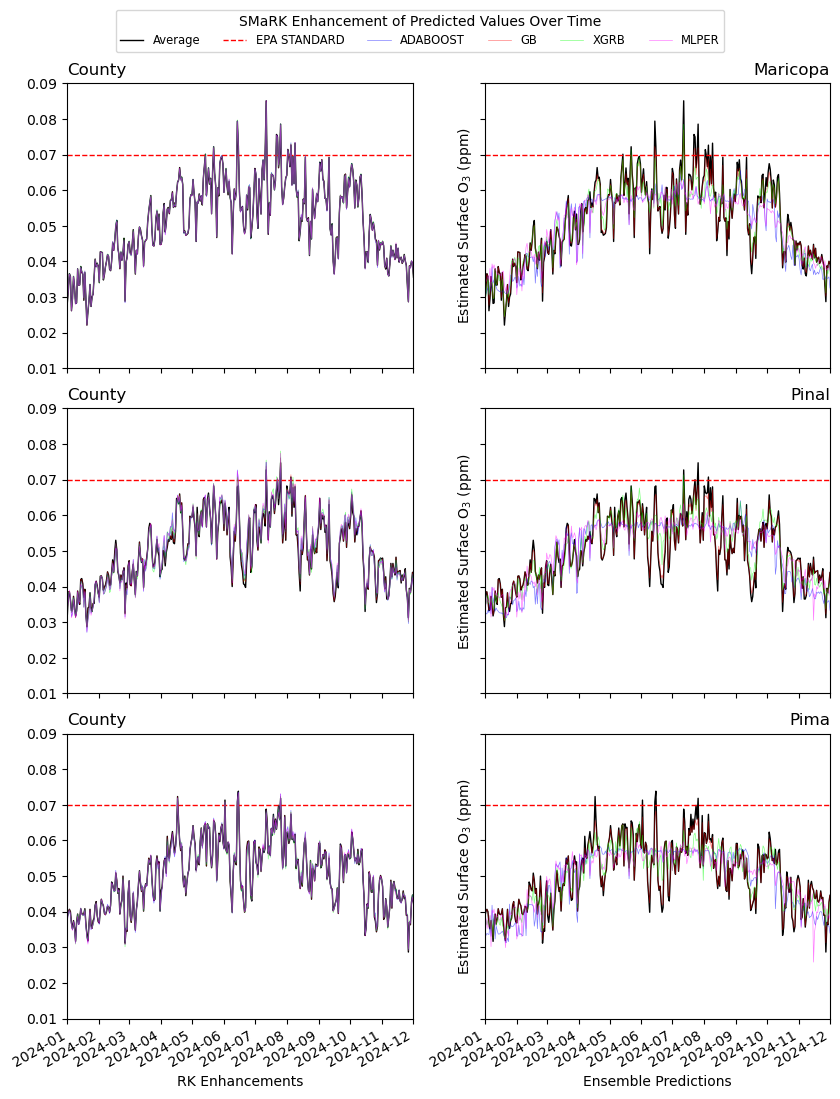

In [ ]:
preds_over_time(predictive_model,'theory_testing.png')

In [ ]:
np.unique(predictive_features.site_id)

array([40130019, 40131003, 40131004, 40131010, 40132001, 40132005,
       40133002, 40133003, 40134003, 40134004, 40134005, 40134008,
       40134010, 40134011, 40137021, 40137024, 40139508, 40139702,
       40139704, 40139997, 40190021, 40191011, 40191018, 40191020,
       40191028, 40191030, 40213001, 40213003, 40213007, 40218001])

In [ ]:
len(np.unique(predictive_features.site_id))

30

In [ ]:
from matplotlib.lines import Line2D
def preds_over_time(df,fname=""):
  path_to_final_images = os.path.join(os.path.expanduser('~'),'Documents','Github','UCBMasters','writing','imgs')
  final_path = os.path.join(path_to_final_images,fname)
  df=predictive_model.copy()
  df['date'] = pd.to_datetime(df['date'])
  df['county'] = df['site_id'].astype(str).str[:4].map({
      '4013': 'Maricopa',
      '4021': 'Pinal',
      '4019': 'Pima'
  }).fillna('Other')
  df = df.groupby(['county', 'date']).mean(numeric_only=True).reset_index()
  raw_vars = ['adaboost_preds',
              'gb_preds',
              'xgrb_preds',
              'mlper_preds']
  rk_vars  = [col for col in df.columns if col.endswith('_rk_preds')]
  color_map = {
      'adaboost_preds':  '#0000FF',
      'gb_preds':        '#FF0000',
      'xgrb_preds':      '#00FF00',
      'mlper_preds':     '#00FFFF'
  }
  counties = ['Maricopa', 'Pinal', 'Pima']
  fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8.5, 11), sharex=True, sharey=True)
  for i, county in enumerate(counties):
      data = df[df['county'] == county].sort_values('date')
      ax_raw = axes[i, 1]
      ax_raw.plot(data['date'], data['max_value'], color='black',linewidth=1)
      for var in raw_vars:
          ax_raw.plot(data['date'], data[var],
                      label=var.replace('_preds', ''),
                      color=color_map[var],
                      alpha=0.5,linewidth=0.5)
      ax_raw.set_title(f"{county}",loc='right')
      ax_raw.set_ylabel("Estimated Surface O$_{3}$ (ppm)")
      ax_raw.set_ylim(bottom=0.01, top=0.09)
      if i == 2:
          ax_raw.set_xlabel("Ensemble Predictions")
      ax_rk = axes[i, 0]
      ax_rk.plot(data['date'], data['max_value'], color='black',linewidth=1)
      for var in rk_vars:
          ax_rk.plot(data['date'], data[var],
                     color=color_map.get(var.replace('_rk_preds', '_preds')),
                     alpha=0.5,linewidth=0.5)
      ax_rk.set_title(f"County",loc='left')
      ax_rk.set_ylim(bottom=0.01, top=0.09)
      if i == 2:
          ax_rk.set_xlabel("RK Enhancements")
      if i == 0:
          legend_handles, legend_labels = ax_raw.get_legend_handles_labels()
  avgh=Line2D([0], [0], color='#000000', linewidth=1, label='Average')
  legend_handles = [avgh] + legend_handles
  legend_labels = ['Average'] + [label.upper() for label in legend_labels]
  fig.legend(legend_handles, legend_labels, title="SMaRK Enhancement of Predicted Values Over Time", fontsize="small", loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.00))
  fig.autofmt_xdate(rotation=45, ha='left')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.savefig(final_path,dpi=500)
  plt.show()





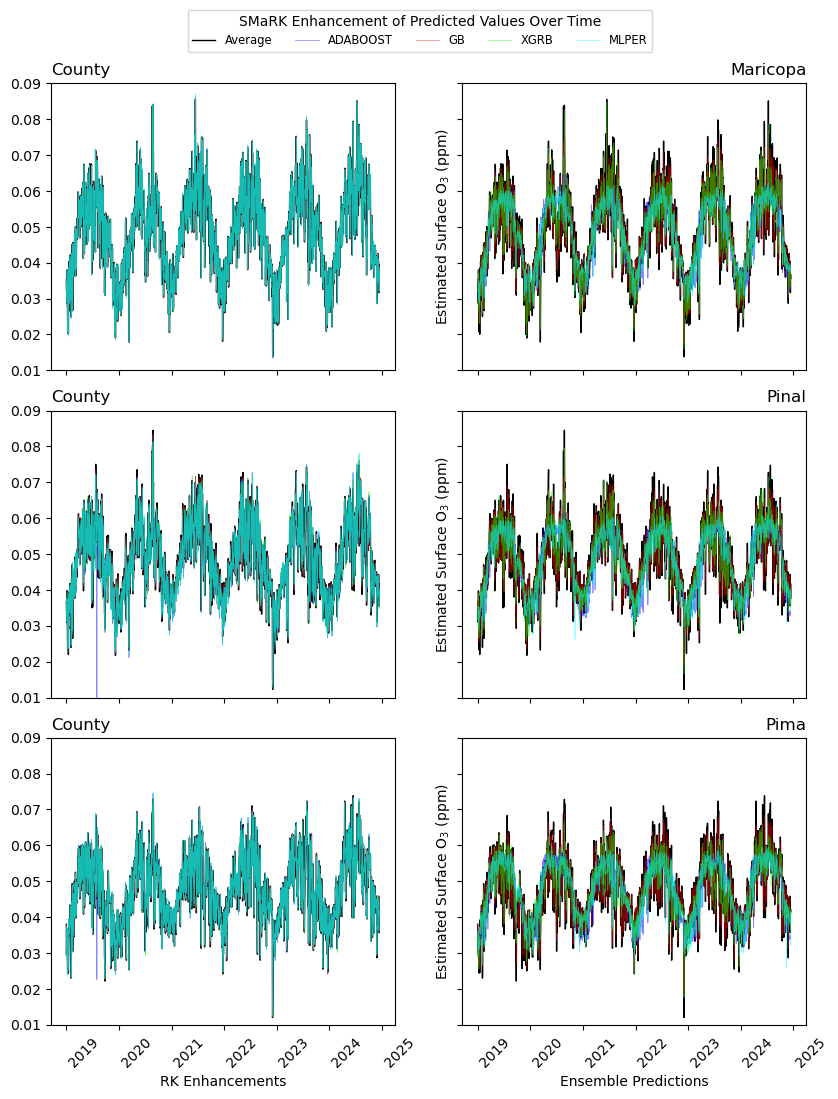

In [ ]:
preds_over_time(predictive_model,'theory_testing.png')

In [ ]:
# Predictions:
# SM, RK
# Final
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import rasterio as rio
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from geopandas import gpd
from sklearn.base import clone 
import matplotlib.pyplot as plt

In [ ]:
def get_metrics(df):
  predictive_cols = [col for col in df.columns if col.endswith('_preds')]
  metrics = []
  for col in predictive_cols:
    mse = mean_squared_error(df['max_value'], df[col])
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(df['max_value'], df[col])
    metrics.append({
      'Model': col,
      'RMSE': rmse,
      'MAE': mae,
      'MSE': mse})
  metrics_df = pd.DataFrame(metrics).sort_values(by='RMSE')
  print(f'  Best Method: {metrics_df.iloc[0]['Model']}')
  best_predictive_column = metrics_df.iloc[0]['Model']
  return best_predictive_column

In [ ]:
x_plot=os.path.join(os.path.expanduser('~'), 'Documents', 'Github', 'UCBMasters', 'data', 'tifs', 'predicted_grids')
ysm_plot=os.path.join(os.path.expanduser('~'), 'Documents','Github','UCBMasters','data','results','final_surfo3','ml_outputs')
yrk_plot=os.path.join(os.path.expanduser('~'), 'Documents','Github','UCBMasters','data','results','final_surfo3','rk_outputs')
yfin_plot=os.path.join(os.path.expanduser('~'), 'Documents','Github','UCBMasters','data','results','final_surfo3')
path_to_final_tables = os.path.join(os.path.expanduser('~'), "Documents", "Github", "UCBMasters", "data",'tables','final')
path_to_final_images = os.path.join(os.path.expanduser('~'), "Documents", "Github", "UCBMasters", "writing",'imgs')

income_data = pd.read_csv(os.path.join(os.path.expanduser('~'), "OneDrive", "Desktop",'ozone_map_data','income_pop_tables','ACS_ST_5Y_income_2019.csv'))
shape = gpd.read_file(os.path.join(os.path.expanduser('~'), "Documents", "Github", "UCBMasters", "data",'azcounty','income_shp','photuc_centracts.shp'))
out = os.path.join(os.path.expanduser('~'), "Documents", "Github", "UCBMasters", "data",'tables','mapping','acs5yincome2019.csv')
csv_path = os.path.join(os.path.expanduser('~'), "Documents", "Github", "UCBMasters", "data",'tables','ad_viz_tile_data.csv')
df = pd.read_csv(csv_path)

predictive_model = pd.read_csv(os.path.join(path_to_final_tables,'theory_model_results.csv'),index_col=0)
predictive_params = pd.read_csv(os.path.join(path_to_final_tables,'theory_goat_model_params.csv'),index_col=0)
predictive_features = pd.read_csv(os.path.join(path_to_final_tables,'theory_goat_model_features.csv'),index_col=0)

In [ ]:

pred_params = pd.read_csv(os.path.join(path_to_final_tables,'hist_model_params_seasons.csv'),index_col=0)
ictive_params = pd.read_csv(os.path.join(path_to_final_tables,'modern_model_params_seasons.csv'),index_col=0)
ive_params = pd.read_csv(os.path.join(path_to_final_tables,'theory_goat_model_params.csv'),index_col=0)
iiearams = pd.read_csv(os.path.join(path_to_final_tables,'goat_model_params.csv'),index_col=0)

for name in choices.keys():
    pred_par = pred_params.reset_index(drop=True).at[0, f'{name}_params']
    ictive_par = ictive_params.reset_index(drop=True).at[0, f'{name}_params']
    ive_par = ive_params.reset_index(drop=True).at[0, f'{name}_params']
    iiear = iiearams.reset_index(drop=True).at[0, f'{name}_params']
    print(pred_par)
    print(ictive_par)
    print(ive_par)
    print(iiear)

{'n_estimators': 230, 'loss': 'linear', 'learning_rate': 0.20000800000000002}
{'n_estimators': 410, 'loss': 'linear', 'learning_rate': 0.600004}
{'n_estimators': 50, 'loss': 'linear', 'learning_rate': 1.0}
{'n_estimators': 131, 'loss': 'linear', 'learning_rate': 0.09091818181818181}
{'tol': 0.001, 'n_estimators': 411, 'max_depth': 4, 'loss': 'absolute_error', 'learning_rate': 0.01584893192461114, 'ccp_alpha': 0.0}
{'tol': 0.01, 'n_estimators': 144, 'max_depth': 8, 'loss': 'huber', 'learning_rate': 0.01584893192461114, 'ccp_alpha': 0.0}
{'tol': 0.0001, 'n_estimators': 366, 'max_depth': None, 'loss': 'absolute_error', 'learning_rate': 0.01, 'ccp_alpha': 0.0}
{'tol': 0.01, 'n_estimators': 233, 'max_depth': 7, 'loss': 'absolute_error', 'learning_rate': 0.012328467394420659, 'ccp_alpha': 0.027272727272727275}
{'reg_lambda': 1.0, 'n_estimators': 400, 'learning_rate': 0.07692307692307693, 'importance_type': 'weight', 'grow_policy': 'lossguide'}
{'reg_lambda': 1.0, 'n_estimators': 450, 'learni